# Lab Week 13 - Visualization & Fine-Tuning


#Trasnfer learning (Review and Practice)

## Reusing pre-trained networks
It is very useful to utilize this pre-trained network for feature detection in any images that might resemble those from benchmark databases such as ImageNet and then train a new fully connected network to classify our costum images using these features.


![](https://dev-to-uploads.s3.amazonaws.com/i/2oyycxxs02jmcghplwc4.png)




## Helper functions

In [1]:
import matplotlib.pyplot as plt
def plot_history(history, color='blue', prefix=""):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)

    # Make a figure with two subplots side by side
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs, loss_values, "o",  color=color, label=prefix + " Training loss")
    plt.plot(epochs, val_loss_values, color=color, label=prefix + " Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(framealpha=0.5)
    plt.grid()

    plt.subplot(1, 2, 2)
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    plt.plot(epochs, acc_values, "o", color=color , label=prefix + " Training accuracy")
    plt.plot(epochs, val_acc_values, color=color, label=prefix + " Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(framealpha=0.5)
    plt.grid()

## Loading the data

We will be using the same cats and dogs dataset from the last week, but downloded in simpler way.

In [2]:
## Download a zip with a subset of the cats and dogs from Gootl Drive
!gdown 1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS

Downloading...
From (original): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS
From (redirected): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS&confirm=t&uuid=dd348a72-256e-416e-ac7e-452bf0b9d66a
To: /Users/mehdiazad/Library/CloudStorage/GoogleDrive-m.abbasiazad@gmail.com/My Drive/COMP3132/LabWeek13/catsVdogs_small.zip
100%|█████████████████████████████████████████| 114M/114M [00:00<00:00, 133MB/s]


In [3]:
!unzip -o -q catsVdogs_small.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [4]:
# imports and setup

import numpy as np
import matplotlib.pylab as plt

import os, shutil, pathlib

import keras
from keras import layers

new_base_dir = pathlib.Path('small')


**Using `image_dataset_from_directory` to read images**

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2025-03-31 22:33:18.187872: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-31 22:33:18.188060: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-31 22:33:18.188073: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-31 22:33:18.188281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 22:33:18.188297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

**TODO: Iterate over `train_dataset` and take one sample batch and labels, print the shape of the batch and save it in `sample_batch` variable**

In [6]:
#your code here

**TODO: Display one image from the sample batch and print the shape of the image**

- Take one sample from the sample batch by accessing it through indexing.

- Use the `.numpy()` method to convert the sample from a `tensor` to a NumPy `array` (since matplotlib works with NumPy arrays).

- Use the `.astype("uint8")` method to convert the NumPy array’s data type to uint8 (unsigned 8-bit integer, range: 0-255, which is the standard format for pixel values).

In [8]:
#you code here

## Part A: Transferring `VGG16` and Adding a Binary Classifier in a Single Architecture

### Instantiating and freezing the VGG16 convolutional base

In [8]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False) ## this means we only get the convolutional part without the densely connected top


conv_base.trainable = False ## This freezes the wieghts on the convolutional part

In [9]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### ConvNet + Densely connected network

**TODO: Pass the preprocessed input from `conv_base and a binary classifier**

- binary classifier architecture:
  - one hideen layer with 256 unit and proper activation function
  - one drop out layer
  - output layer with 1 unit and proper activation function for binary classification. (1: Dog, 0: Cat)

In [10]:
#Solution
from tensorflow.keras import layers, models

classifier = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])


inputs = keras.Input(shape=(180, 180, 3))
processed = keras.applications.xception.preprocess_input(inputs)
features = conv_base(processed) # Convolutional base
flat = layers.Flatten()(features)
outputs = classifier(flat)

model_transfer = keras.Model(inputs, outputs)
intermediate_model = keras.Model(inputs, features)

In [11]:
model_transfer.summary() #look at the param # where the weights are forzen

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │     3,277,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
intermediate_model.summary() 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Compile and train

In [13]:
model_transfer.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
history = model_transfer.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    )

Epoch 1/10


2025-03-31 22:34:31.661371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.7772 - loss: 2.1938 - val_accuracy: 0.9210 - val_loss: 0.2421
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.9281 - loss: 0.2642 - val_accuracy: 0.8970 - val_loss: 0.3310
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.9399 - loss: 0.2353 - val_accuracy: 0.9300 - val_loss: 0.2151
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step - accuracy: 0.9527 - loss: 0.1610 - val_accuracy: 0.9320 - val_loss: 0.2464
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.9594 - loss: 0.1359 - val_accuracy: 0.9360 - val_loss: 0.2291
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.9648 - loss: 0.1325 - val_accuracy: 0.9360 - val_loss: 0.2371
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step - accuracy: 0.9758 - loss: 0.0967 - val_accuracy: 0.8930 - val_loss: 0.5831
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - accuracy: 0.9735 - loss: 0.0820 - val_accuracy: 0.904

### Plotting

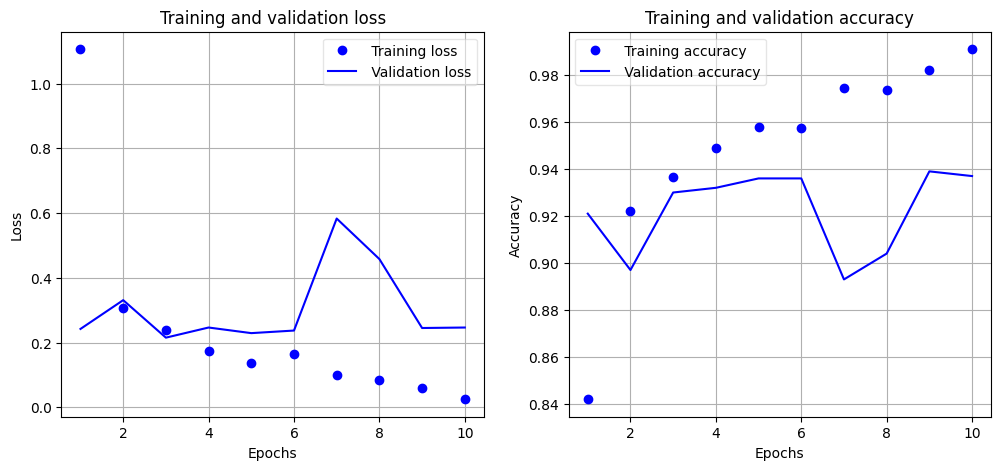

In [15]:
plot_history(history)

### Visualization of layers

**Printing the layer names of a deep learning model**

In [16]:
sample_image = sample_batch[:1]  # Shape should be (1, 180, 180, 3)
print(sample_image.shape)
print(sample_image.dtype)


(1, 180, 180, 3)
<dtype: 'float32'>


In [17]:
intermediate_layer = intermediate_model.predict(sample_image) # this is the output of the convolutional base
intermediate_layer.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


(1, 5, 5, 512)

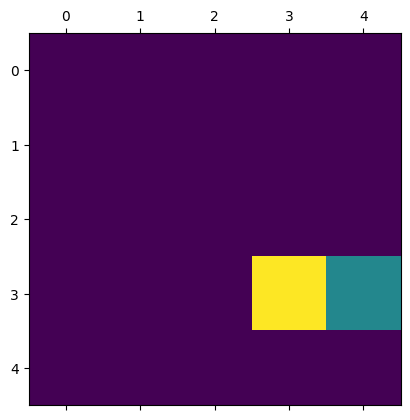

In [18]:
import matplotlib.pyplot as plt

plt.matshow(intermediate_layer[0, :, :, 3], cmap='viridis')
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_maps(intermediate_layer, images_per_row=32):
    n_features = intermediate_layer.shape[-1]
    size = intermediate_layer.shape[1]
    n_cols = n_features // images_per_row

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = intermediate_layer[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

    plt.figure(figsize=(display_grid.shape[1] / size, display_grid.shape[0] / size))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

/var/folders/py/lx68lx7s6sbcr2m9kwtspqvh0000gn/T/ipykernel_13750/2419833797.py:18: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


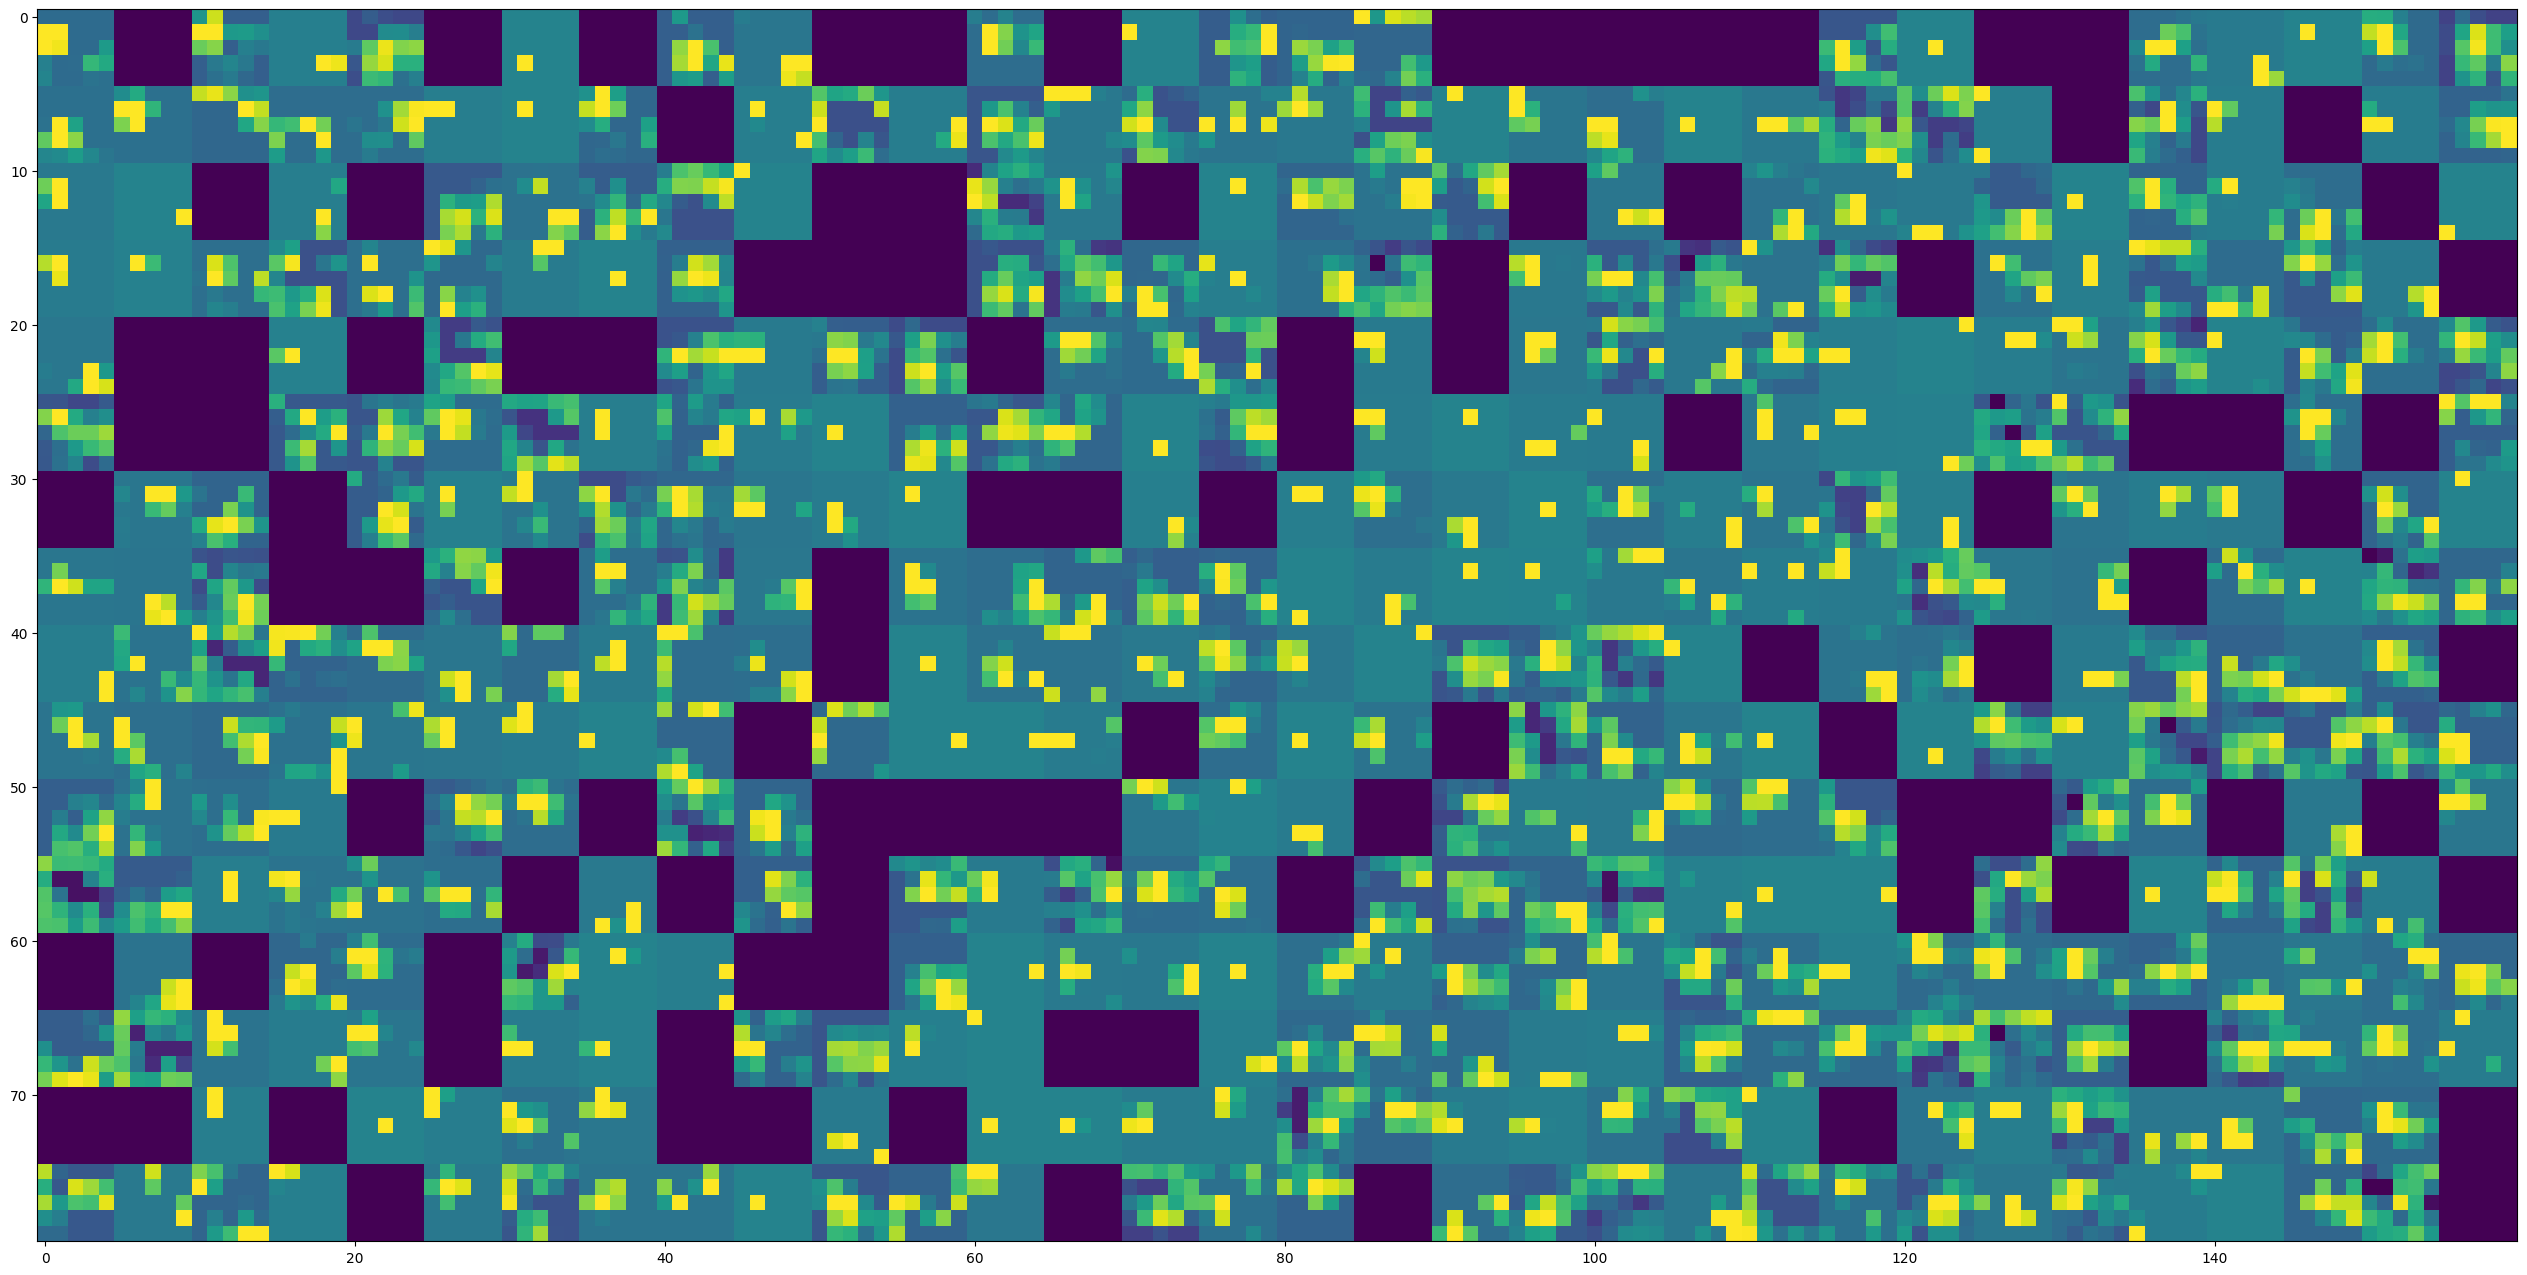

In [21]:
visualize_feature_maps(intermediate_layer)

## Part B: Fine-tuning the VGG16 model

In [ ]:
#import vgg16 without the top 
#you code here
conv_base  = ...


### Unfreezing the last 4 blocks (Important Part!)

In [26]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Fine-tuning the vgg16 model while training the classifier

**define the models: full model with classifier and intermediate model with conv_base**

In [ ]:
#your code here

**Compile and train the model**

In [22]:
#your code here

### Plotting

**Plot your training and validation accuracy and loss**

### Visualization of layers

**Visulalize the feature maps of the last convolutional layer of the VGG16 model**

In [23]:
#your code here